In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import cv2
from cycler import cycler
import matplotlib.colors as mcolors

plt.style.use(['science', 'grid'])
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['font.size'] = 8
plt.rcParams['lines.markersize'] = 2.5
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams['grid.alpha'] = .2

T = lambda I: 108.0958765*I*I*I-511.9765339*I*I+1617.95649045*I+537.60415503

## Оригинальное изображение

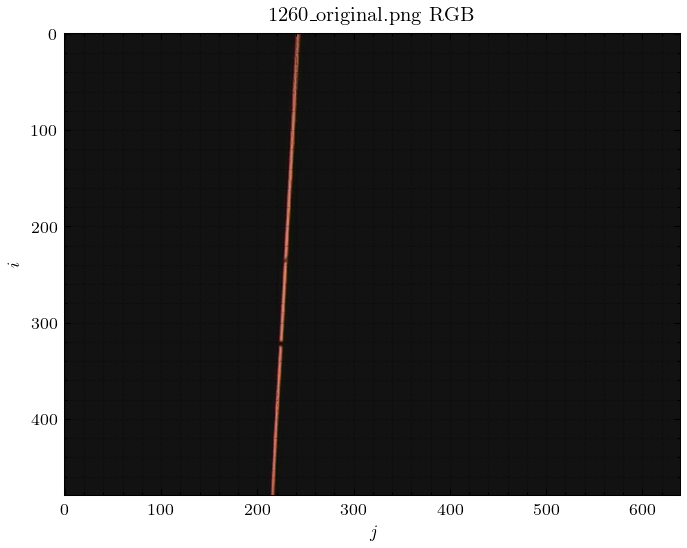

In [2]:
image_name = '1260_original.png'
image = cv2.imread(image_name, cv2.IMREAD_COLOR_RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
red, green, blue = cv2.split(image)

data = {
    'gray':  { 'img': gray  },
    'red':   { 'img': red   },
    'green': { 'img': green },
    'blue':  { 'img': blue  },
}

plt.xlabel('$j$')
plt.ylabel('$i$')
plt.imshow(image)
plt.title(image_name + ' RGB')
plt.show()

## Координаты максимумов

y =  -0.05625 x + 243
std = [0.00014812 0.040984  ]


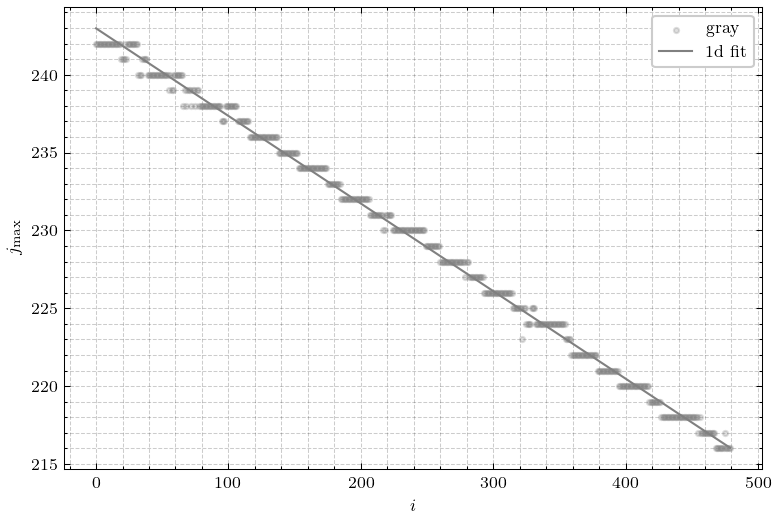

y =  -0.05597 x + 242.9
std = [0.00015844 0.04384029]


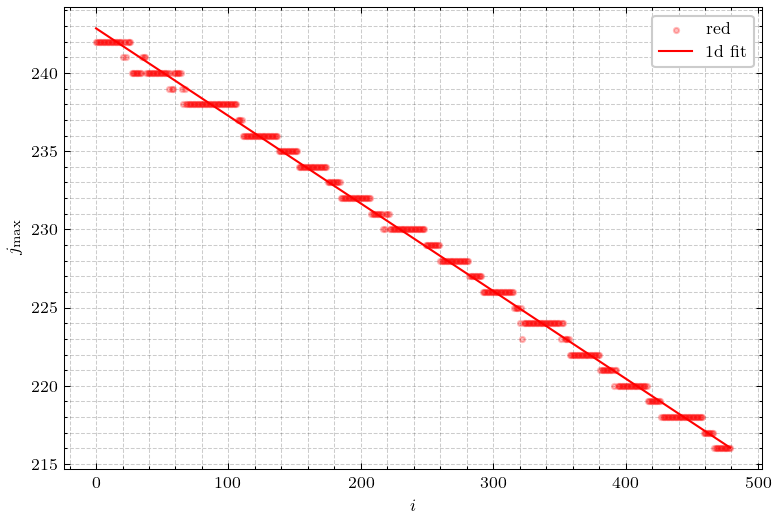

y =  -0.05627 x + 243
std = [0.0001523  0.04213944]


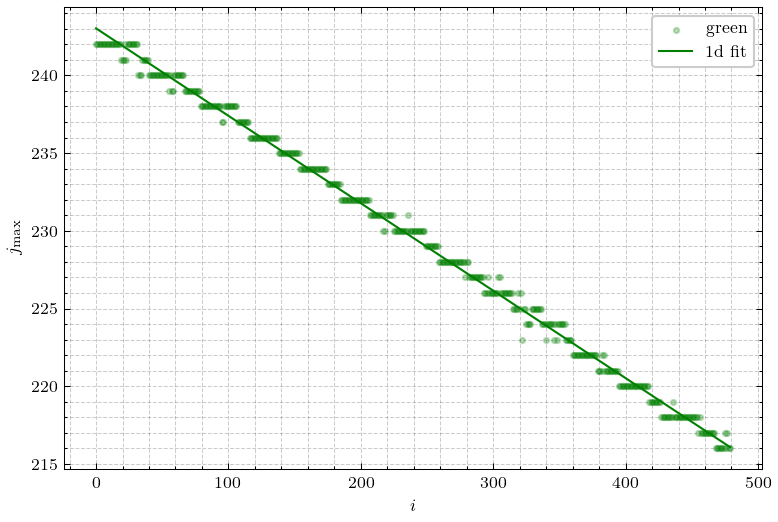

y =  -0.05602 x + 242.8
std = [0.00018382 0.0508632 ]


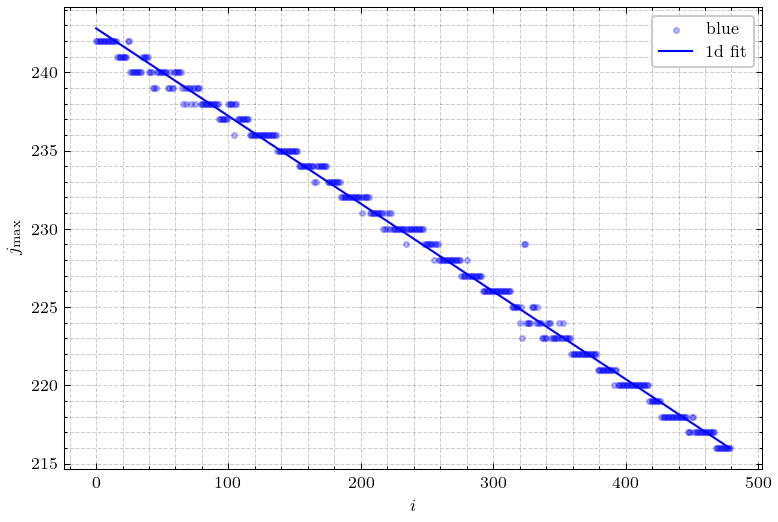

In [3]:
fit_order = 1

def j_maxs(img_array):
    res = []
    for i in range(img_array.shape[0]):
        res.append(np.argmax(img_array[i]))
    return np.array(res)

for color, color_data in data.items():
    img_array = color_data['img']
    i_arr = np.arange(img_array.shape[0])
    j_arr = j_maxs(img_array)
    plt.scatter(i_arr, j_arr, label=color, color=color, alpha=.25)
    popt, pcov = np.polyfit(i_arr, j_arr, fit_order, cov=True)
    p = np.poly1d(popt)
    plt.plot(i_arr, p(i_arr), label=f'{fit_order}d fit', color=color)

    print(f'y = {str(p).replace('\n', '')}')
    print(f'std = {np.sqrt(np.diag(pcov))}') # https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

    plt.xlabel('$i$')
    plt.ylabel(r'$j_\text{max}$')
    plt.legend()
    plt.show()

    color_data['i_arr'] = i_arr
    color_data['j_max'] = j_arr
    color_data['j_fit'] = p(i_arr).round().astype(int)

## Яркость в максимуме и яркость на оси в зависимости от i (одиночные пиксели)

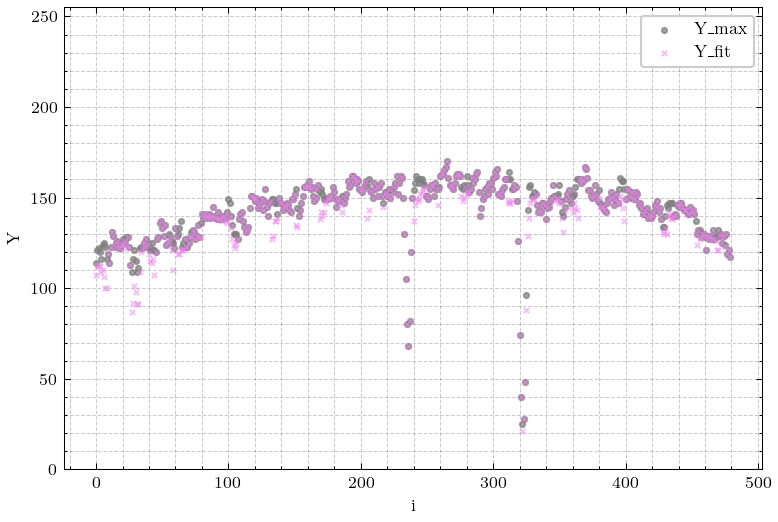

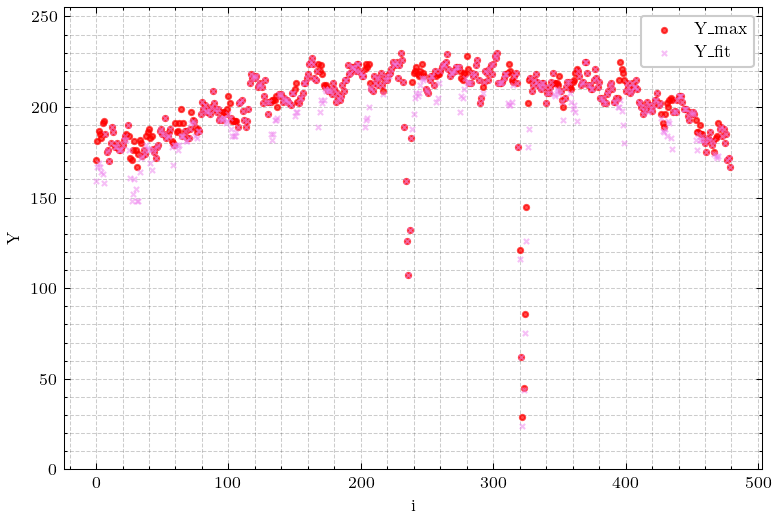

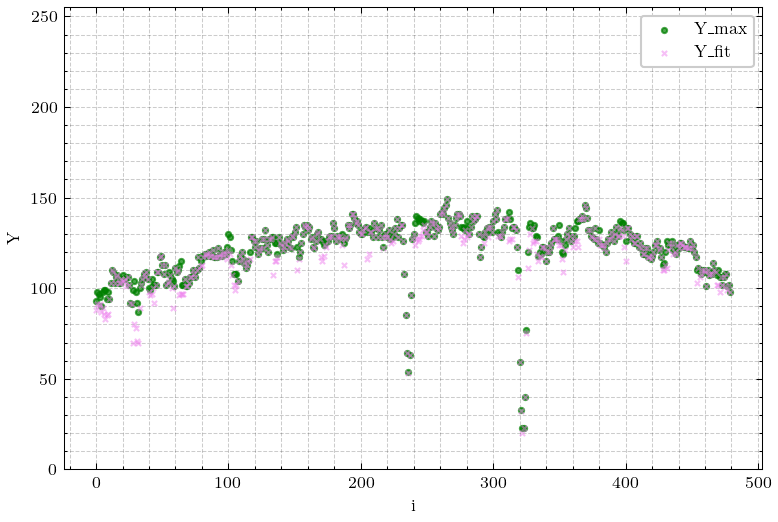

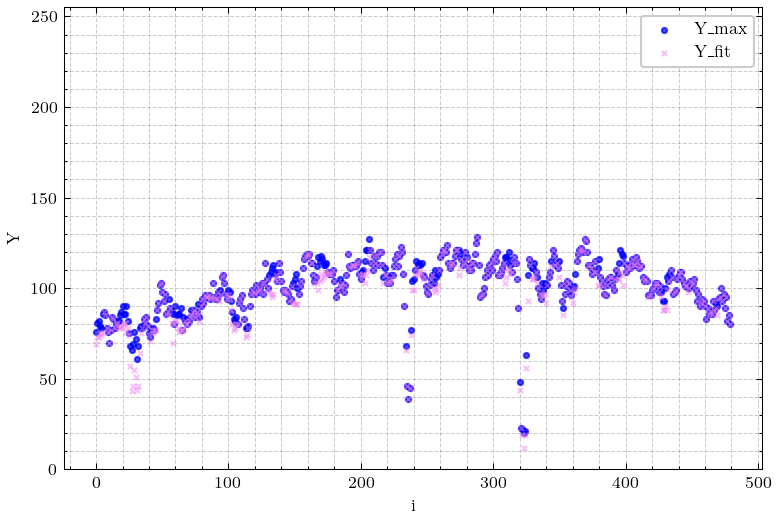

In [4]:
for color, color_data in data.items():
    plt.ylim(0, 255)
    i_arr = color_data['i_arr']
    
    Y_max = color_data['img'][i_arr, color_data['j_max']]
    plt.scatter(i_arr, Y_max, color=color, label='Y_max', marker='o', alpha=.7)

    Y_fit = color_data['img'][i_arr, color_data['j_fit']]
    plt.scatter(i_arr, Y_fit, color='violet', label='Y_fit', marker='x', alpha=.5)

    plt.xlabel('i')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

## Яркость на оси в зависимости от i (усреднение по соседним 3, 5, 7 пикселям)

gray


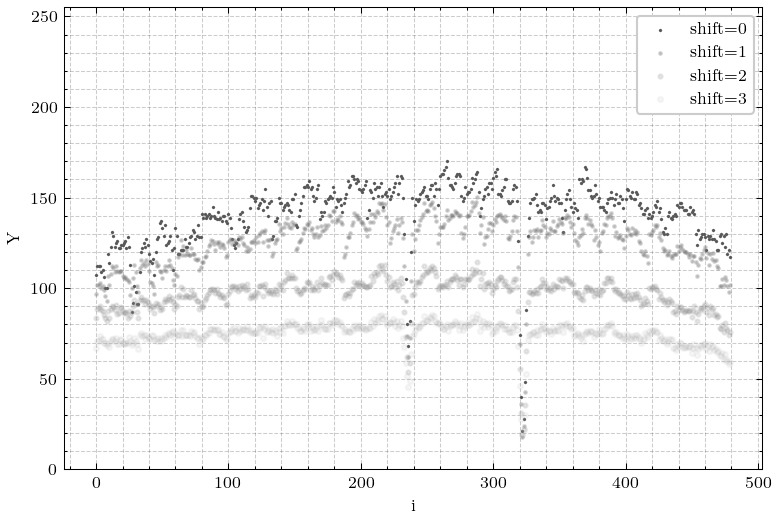

red


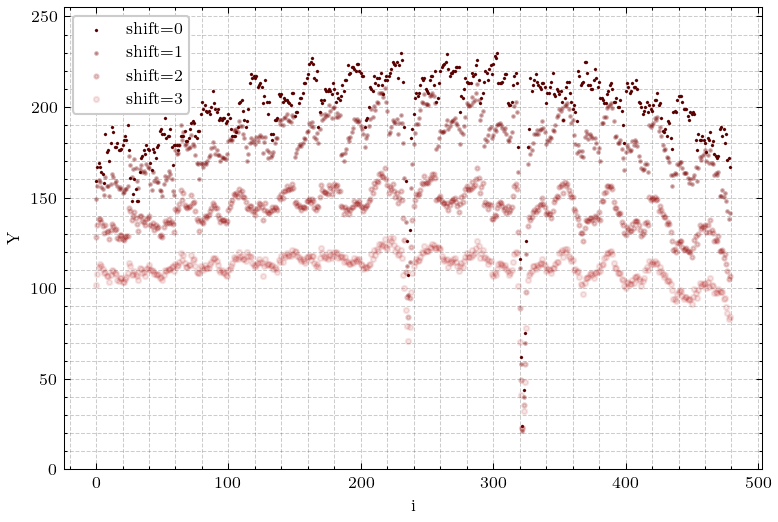

green


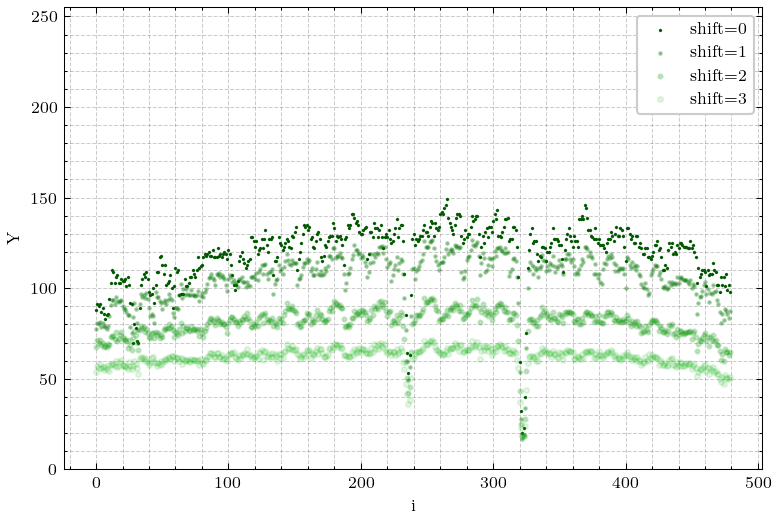

blue


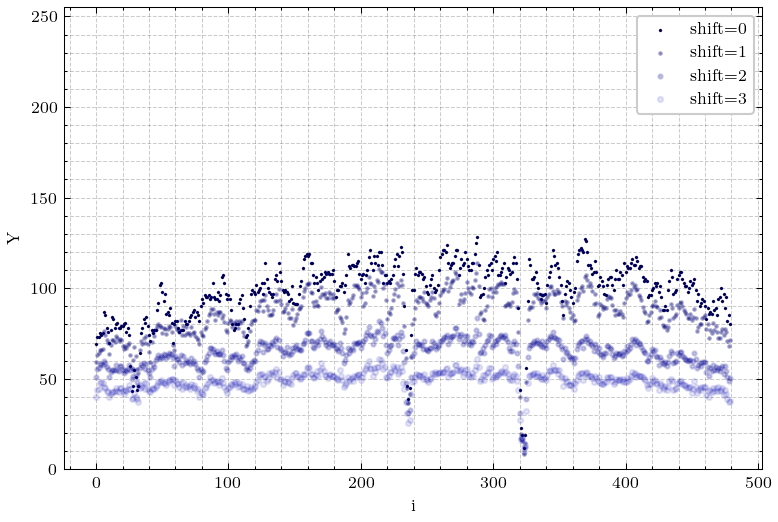

In [5]:
for color, color_data in data.items():
    base_color = mcolors.rgb_to_hsv(mcolors.to_rgb(color))
    colors = [mcolors.hsv_to_rgb((base_color[0], base_color[1], v)) for v in np.linspace(.35, .92, 6)]
    plt.rc('axes', prop_cycle=cycler(color=colors))
    plt.ylim(0, 255)
    print(color)


    i_arr = color_data['i_arr']
    j_fit = color_data['j_fit'].reshape(-1, 1)
    j_idx = j_fit

    Y = color_data['img'][i_arr, color_data['j_fit']]
    plt.scatter(i_arr, Y, label='shift=0', marker='x', s=1)

    for shift in range(1, 4):
        j_idx = np.concat((j_fit - shift, j_idx, j_fit + shift), axis=1)

        Y_data = color_data['img'][i_arr.reshape(-1, 1), j_idx]
        Y = Y_data.mean(axis=1)

        plt.scatter(i_arr, Y, label=f'{shift=}', alpha=.4-shift/10, s=shift*2.4 - .8)
    
    plt.xlabel('i')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

## Средняя пороговая яркость в зависимости от i (порог 0.999, 0.95, 0.9, 0.85, 0.8, 0.75)

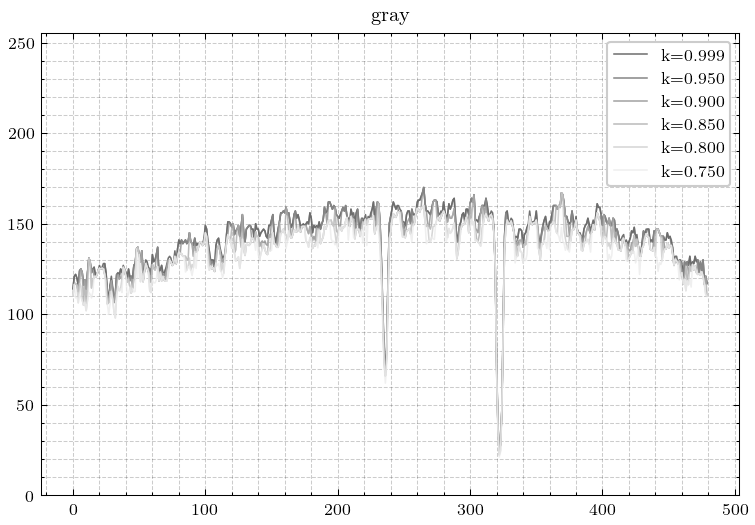

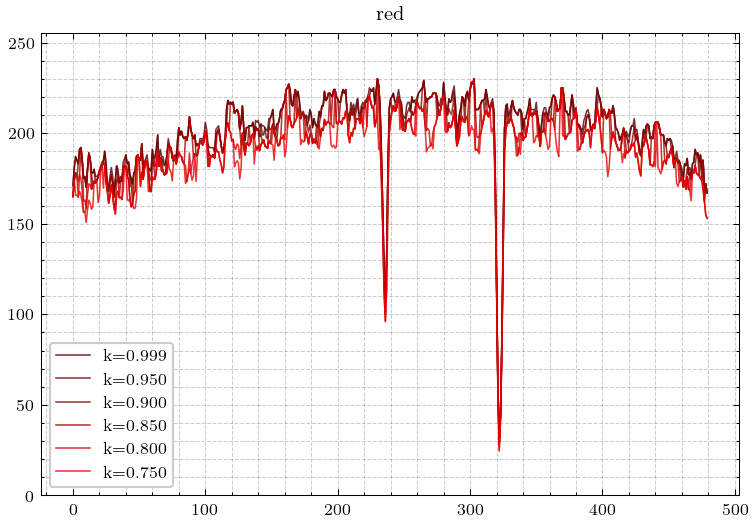

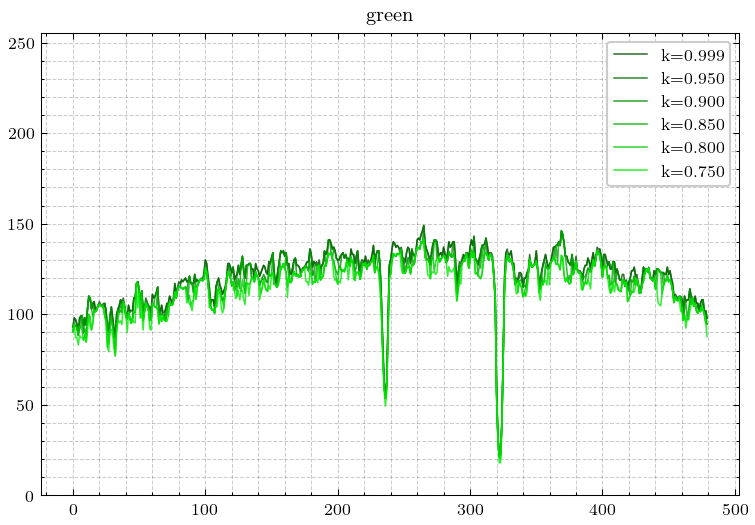

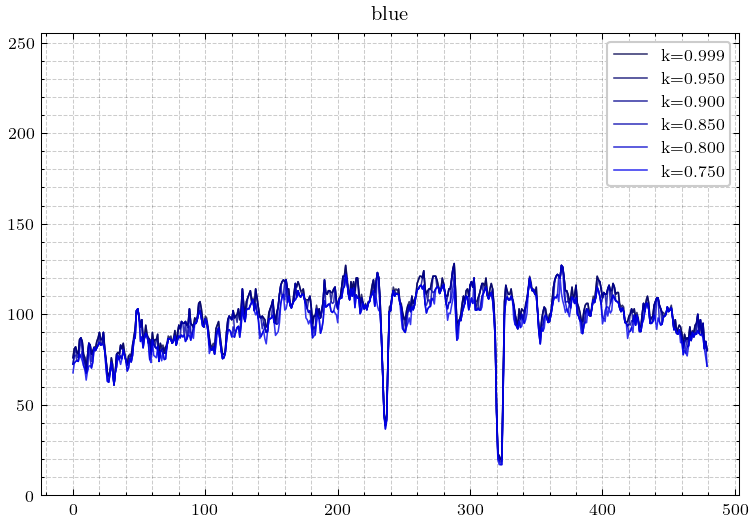

In [6]:
for color, color_data in data.items():
    base_color = mcolors.rgb_to_hsv(mcolors.to_rgb(color))
    colors = [mcolors.hsv_to_rgb((base_color[0], base_color[1], v)) for v in np.linspace(.3, .92, 6)]
    plt.rc('axes', prop_cycle=cycler(color=colors))
    plt.ylim(0, 255)

    i_arr = color_data['i_arr']
    img_array = color_data['img']
    Y_max = img_array.max(axis=1)

    for k in [0.999, 0.95, 0.9, 0.85, 0.8, 0.75]:
        Y_min = Y_max * k
        num_mask = np.ones(shape=img_array.shape) * Y_min.reshape(-1, 1)
        Y = np.ma.masked_array(img_array, img_array <= num_mask).mean(axis=1).data
        plt.plot(i_arr, Y, label=f'{k=:.3f}', lw=.75, alpha=.8)
    
    plt.title(color)
    plt.legend()
    plt.show()